<a href="https://colab.research.google.com/github/Viddesh1/Helmet_test_1/blob/main/kaggle_Helmet_how_to_auto_train_yolov8_model_with_autodistill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Auto Train YOLOv8 Model with Autodistill

Autodistill uses big, slower foundation models to train small, faster supervised models. Using `autodistill`, you can go from unlabeled images to inference on a custom model running at the edge with no human intervention in between.

![Autodistill Steps](https://media.roboflow.com/open-source/autodistill/steps.jpg)

As foundation models get better and better they will increasingly be able to augment or replace humans in the labeling process. We need tools for steering, utilizing, and comparing these models. Additionally, these foundation models are big, expensive, and often gated behind private APIs. For many production use-cases, we need models that can run cheaply and in realtime at the edge.

![Autodistill Connections](https://media.roboflow.com/open-source/autodistill/connections.jpg)

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Image dataset preperation
- Autolabel dataset
- Train target model
- Evaluate target model
- Run video inference
- Upload dataset and model to Roboflow (comming soon)

## 🔥 Let's begin!


## ⚡ Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
# !rm -rf images

In [2]:
# https://www.kaggle.com/datasets/andrewmvd/helmet-detection
# Installing kaggle using pip in quite mode

!pip install -q kaggle

# Mounting the google drive and uploading the kaggle API downloaded from kaggle account.

from google.colab import files, drive

files.upload() # Upload kaggle API here
drive.mount("/content/drive")

# Create a folder to store kaggle dataset on colab

!mkdir -p ~/.kaggle # Creating a directory
!cp kaggle.json ~/.kaggle/ # Copying the kaggle.json API key file to .kaggle directory
!chmod 600 /root/.kaggle/kaggle.json # Giving appropriate permision

# Downloading the datset from kaggle datset API.
# Below is the datset link:-
# https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset

!kaggle datasets download -d andrewmvd/helmet-detection



Saving kaggle.json to kaggle.json
Mounted at /content/drive
 94% 369M/391M [00:02<00:00, 159MB/s]
100% 391M/391M [00:02<00:00, 142MB/s]


In [3]:
# Unzipping the zip file

!unzip /content/helmet-detection.zip

Archive:  /content/helmet-detection.zip
  inflating: annotations/BikesHelmets0.xml  
  inflating: annotations/BikesHelmets1.xml  
  inflating: annotations/BikesHelmets10.xml  
  inflating: annotations/BikesHelmets100.xml  
  inflating: annotations/BikesHelmets101.xml  
  inflating: annotations/BikesHelmets102.xml  
  inflating: annotations/BikesHelmets103.xml  
  inflating: annotations/BikesHelmets104.xml  
  inflating: annotations/BikesHelmets105.xml  
  inflating: annotations/BikesHelmets106.xml  
  inflating: annotations/BikesHelmets107.xml  
  inflating: annotations/BikesHelmets108.xml  
  inflating: annotations/BikesHelmets109.xml  
  inflating: annotations/BikesHelmets11.xml  
  inflating: annotations/BikesHelmets110.xml  
  inflating: annotations/BikesHelmets111.xml  
  inflating: annotations/BikesHelmets112.xml  
  inflating: annotations/BikesHelmets113.xml  
  inflating: annotations/BikesHelmets114.xml  
  inflating: annotations/BikesHelmets115.xml  
  inflating: annotations/B

In [4]:
!nvidia-smi

Wed Oct 11 16:51:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 🧪 Install autodistill

**NOTE:** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In [5]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
supervision==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.0 MB/s eta 0:00:00


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [6]:
import os
HOME = os.getcwd()
print(HOME)

/content


## 🖼️ Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a set of images that you want to automatically annotate, and use for target model training.

In [7]:
!mkdir {HOME}/images

mkdir: cannot create directory ‘/content/images’: File exists


**NOTE:** If you want to build YOLOv8 on your data make sure to upload it into `images` directory that we just created. ☝️

### Download raw videos (optional)

**NOTE:** In this tutorial, we will start with a directory containing video files and I will show you how to turn it into a ready-to-use collection of images. If you are working with your images, you can skip this part.

In [8]:
# !mkdir {HOME}/videos
# %cd {HOME}/videos
# # Upload he2.mp4 video in videos folder.


In [9]:
# !mkdir {HOME}/videos
# %cd {HOME}/videos

# # download zip file containing videos
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt" -O milk.zip && rm -rf /tmp/cookies.txt

# # unzip videos
# !unzip milk.zip

### Convert videos into images (optional)

**NOTE:** Now, let's convert videos into images. By default, the code below saves every `10th` frame from each video. You can change this by manipulating the value of the `FRAME_STRIDE` parameter.

In [10]:
VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 3

**NOTE:** Notice that we put two of our videos aside so that we can use them at the end of the notebook to evaluate our model.

In [11]:
# import supervision as sv
# from tqdm.notebook import tqdm

# video_paths = sv.list_files_with_extensions(
#     directory=VIDEO_DIR_PATH,
#     extensions=["mov", "mp4"])

# print(video_paths)

# for video_path in tqdm(video_paths):
#     video_name = video_path.stem
#     image_name_pattern = video_name + "-{:05d}.png"
#     with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
#         for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
#             sink.save_image(image=image)

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [12]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 764


**NOTE:** We can also plot sample of our image dataset.

In [13]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

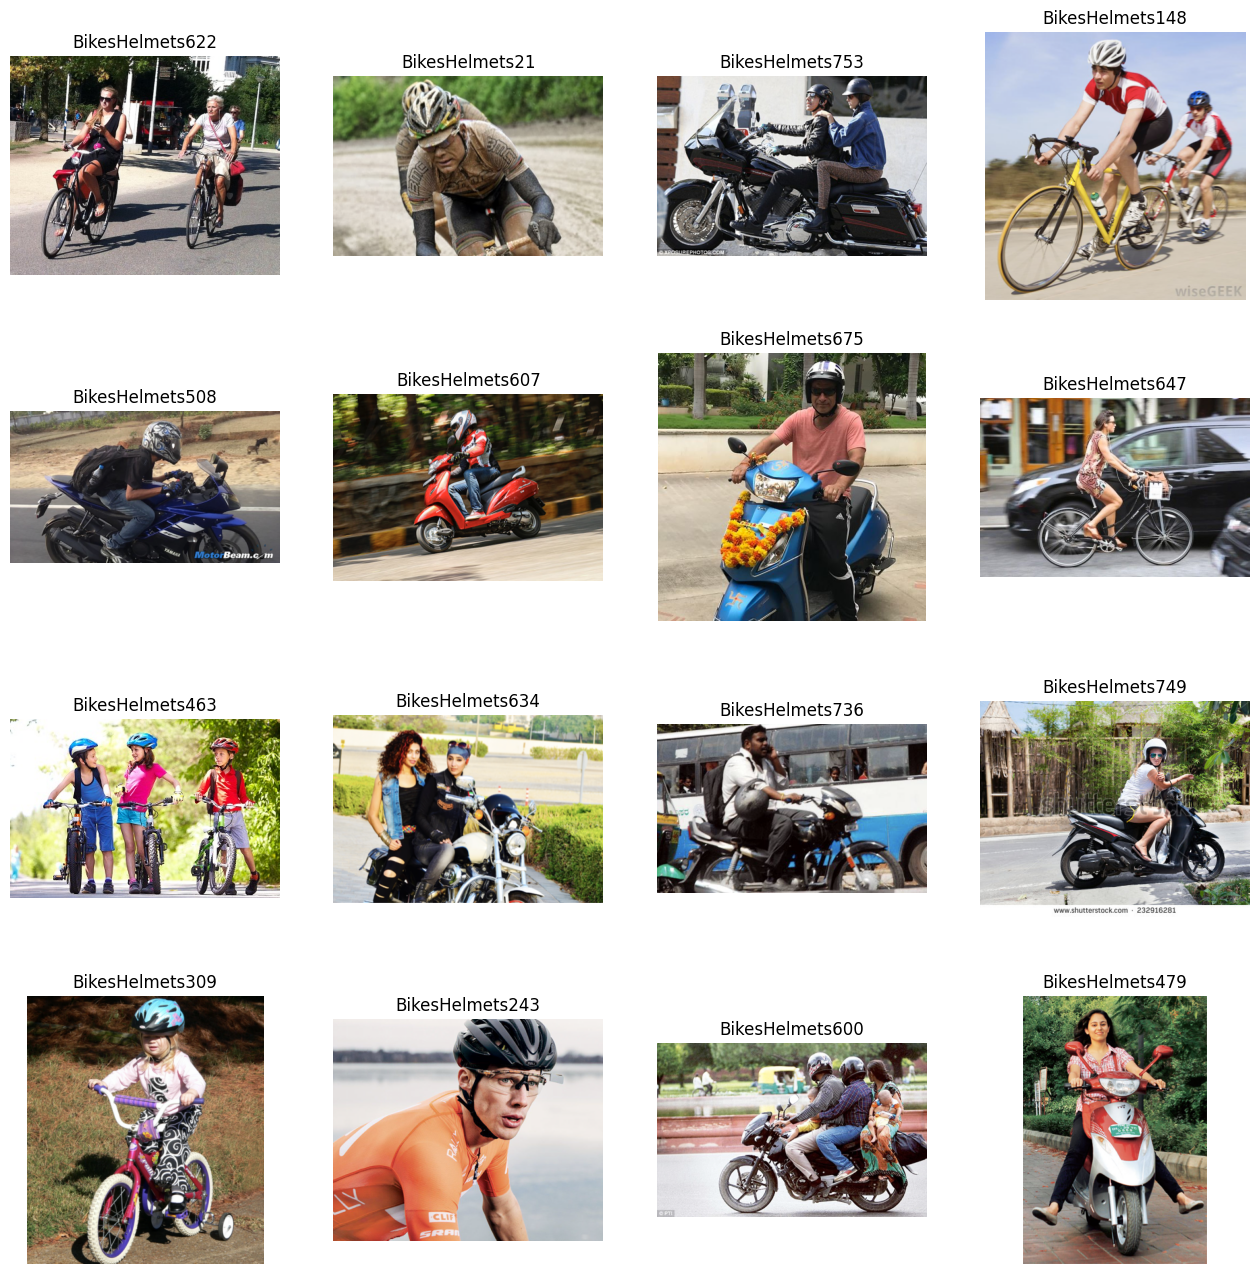

In [14]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [15]:
# !mkdir -p /content/other_images

# import os

# source_dir = '/content/images'
# destination_dir = '/content/other_images'

# # Get a list of all the PNG files in the source directory.
# png_files = []
# for file in os.listdir(source_dir):
#     if file.endswith('.png'):
#         png_files.append(file)

# # Create a new list containing only the PNG files that we want to copy.
# files_to_copy = []
# for i in range(len(png_files)):
#     if i >= 60:
#         files_to_copy.append(png_files[i])

# # Copy the PNG files to the destination directory.
# for file in files_to_copy:
#     # Check if the destination file exists. If it does, then skip it.
#     if os.path.exists(os.path.join(destination_dir, file)):
#         continue

#     # Copy the file to the destination directory.
#     os.rename(os.path.join(source_dir, file), os.path.join(destination_dir, file))



In [16]:
# !rm -rf /content/other_images

In [17]:
from autodistill.detection import CaptionOntology

    # "bike rider": "Bike_Rider",
    # "bike rider and passanger with helmet": "Helmet",
    # "bike rider and passanger with no helmet": "No_Helmet"

ontology=CaptionOntology({
    "bike rider": "Bike_Rider",
    "helmet": "Helmet",
    "no helmet": "No_Helmet"
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [18]:
DATASET_DIR_PATH = f"{HOME}/dataset"

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [19]:
# TO Be deleted for test purpose only
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 764


In [20]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
downloading dino model weights


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Labeling /content/images/BikesHelmets622.png:   0%|          | 0/764 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Labeling /content/images/BikesHelmets583.png: 100%|██████████| 764/76

Labeled dataset created - ready for distillation.


### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [21]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [22]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

611

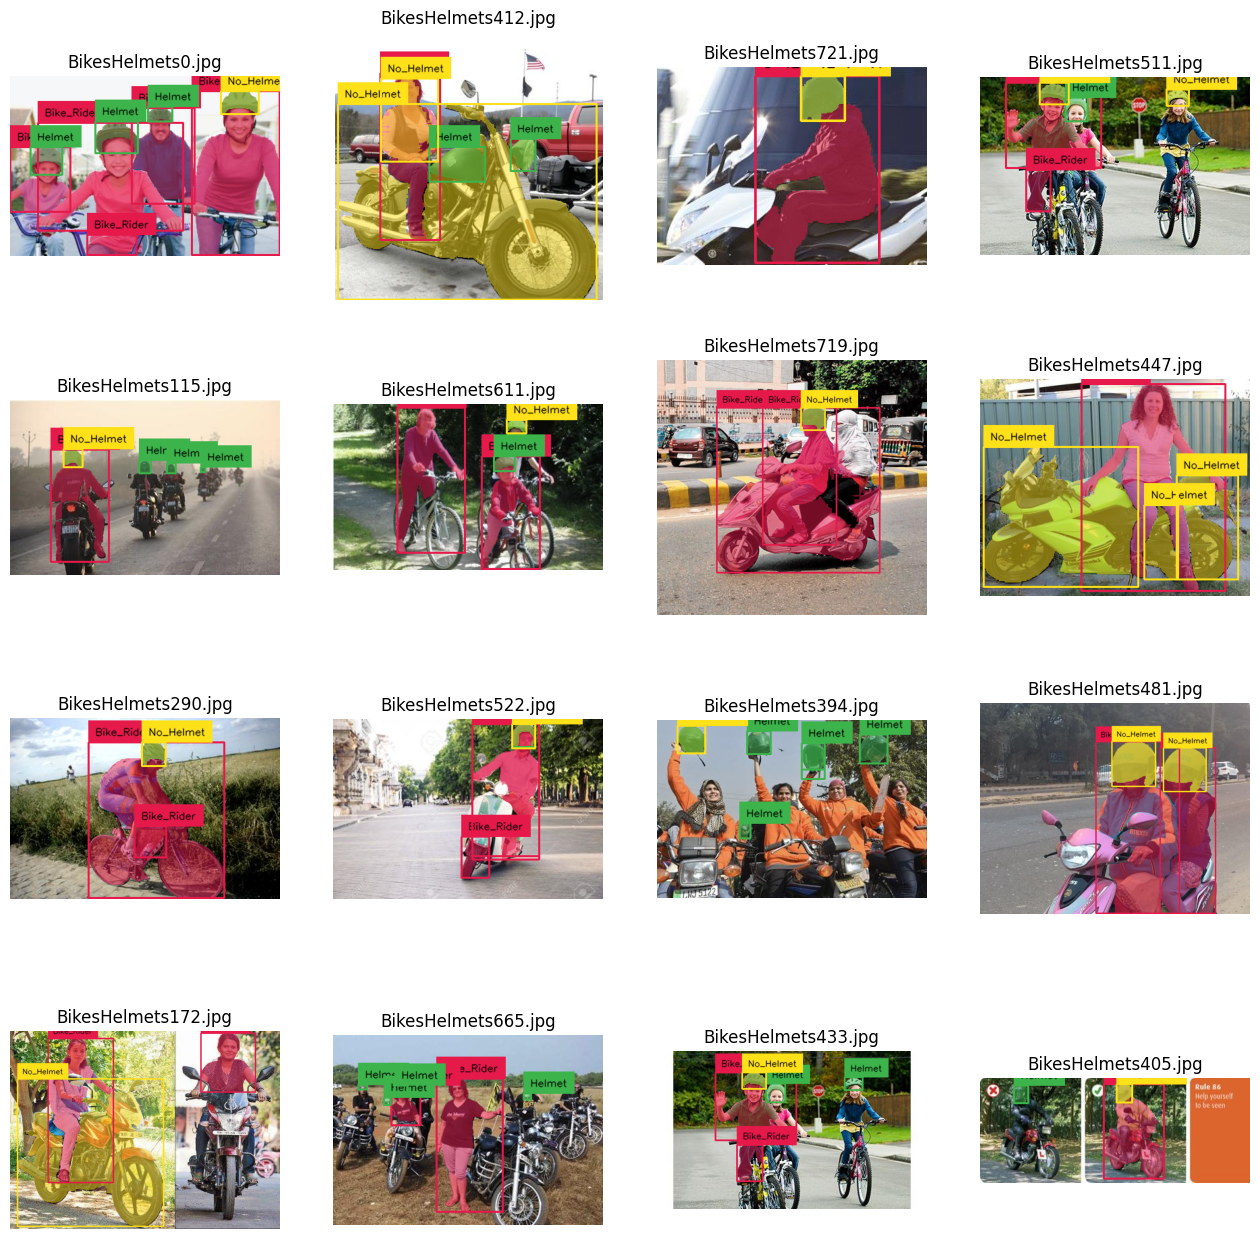

In [23]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [24]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8l.pt")
target_model.train(DATA_YAML_PATH, epochs=50) #100

/content


100%|██████████| 83.7M/83.7M [00:00<00:00, 196MB/s]
New https://pypi.org/project/ultralytics/8.0.196 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/dataset/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, aug

## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

/content


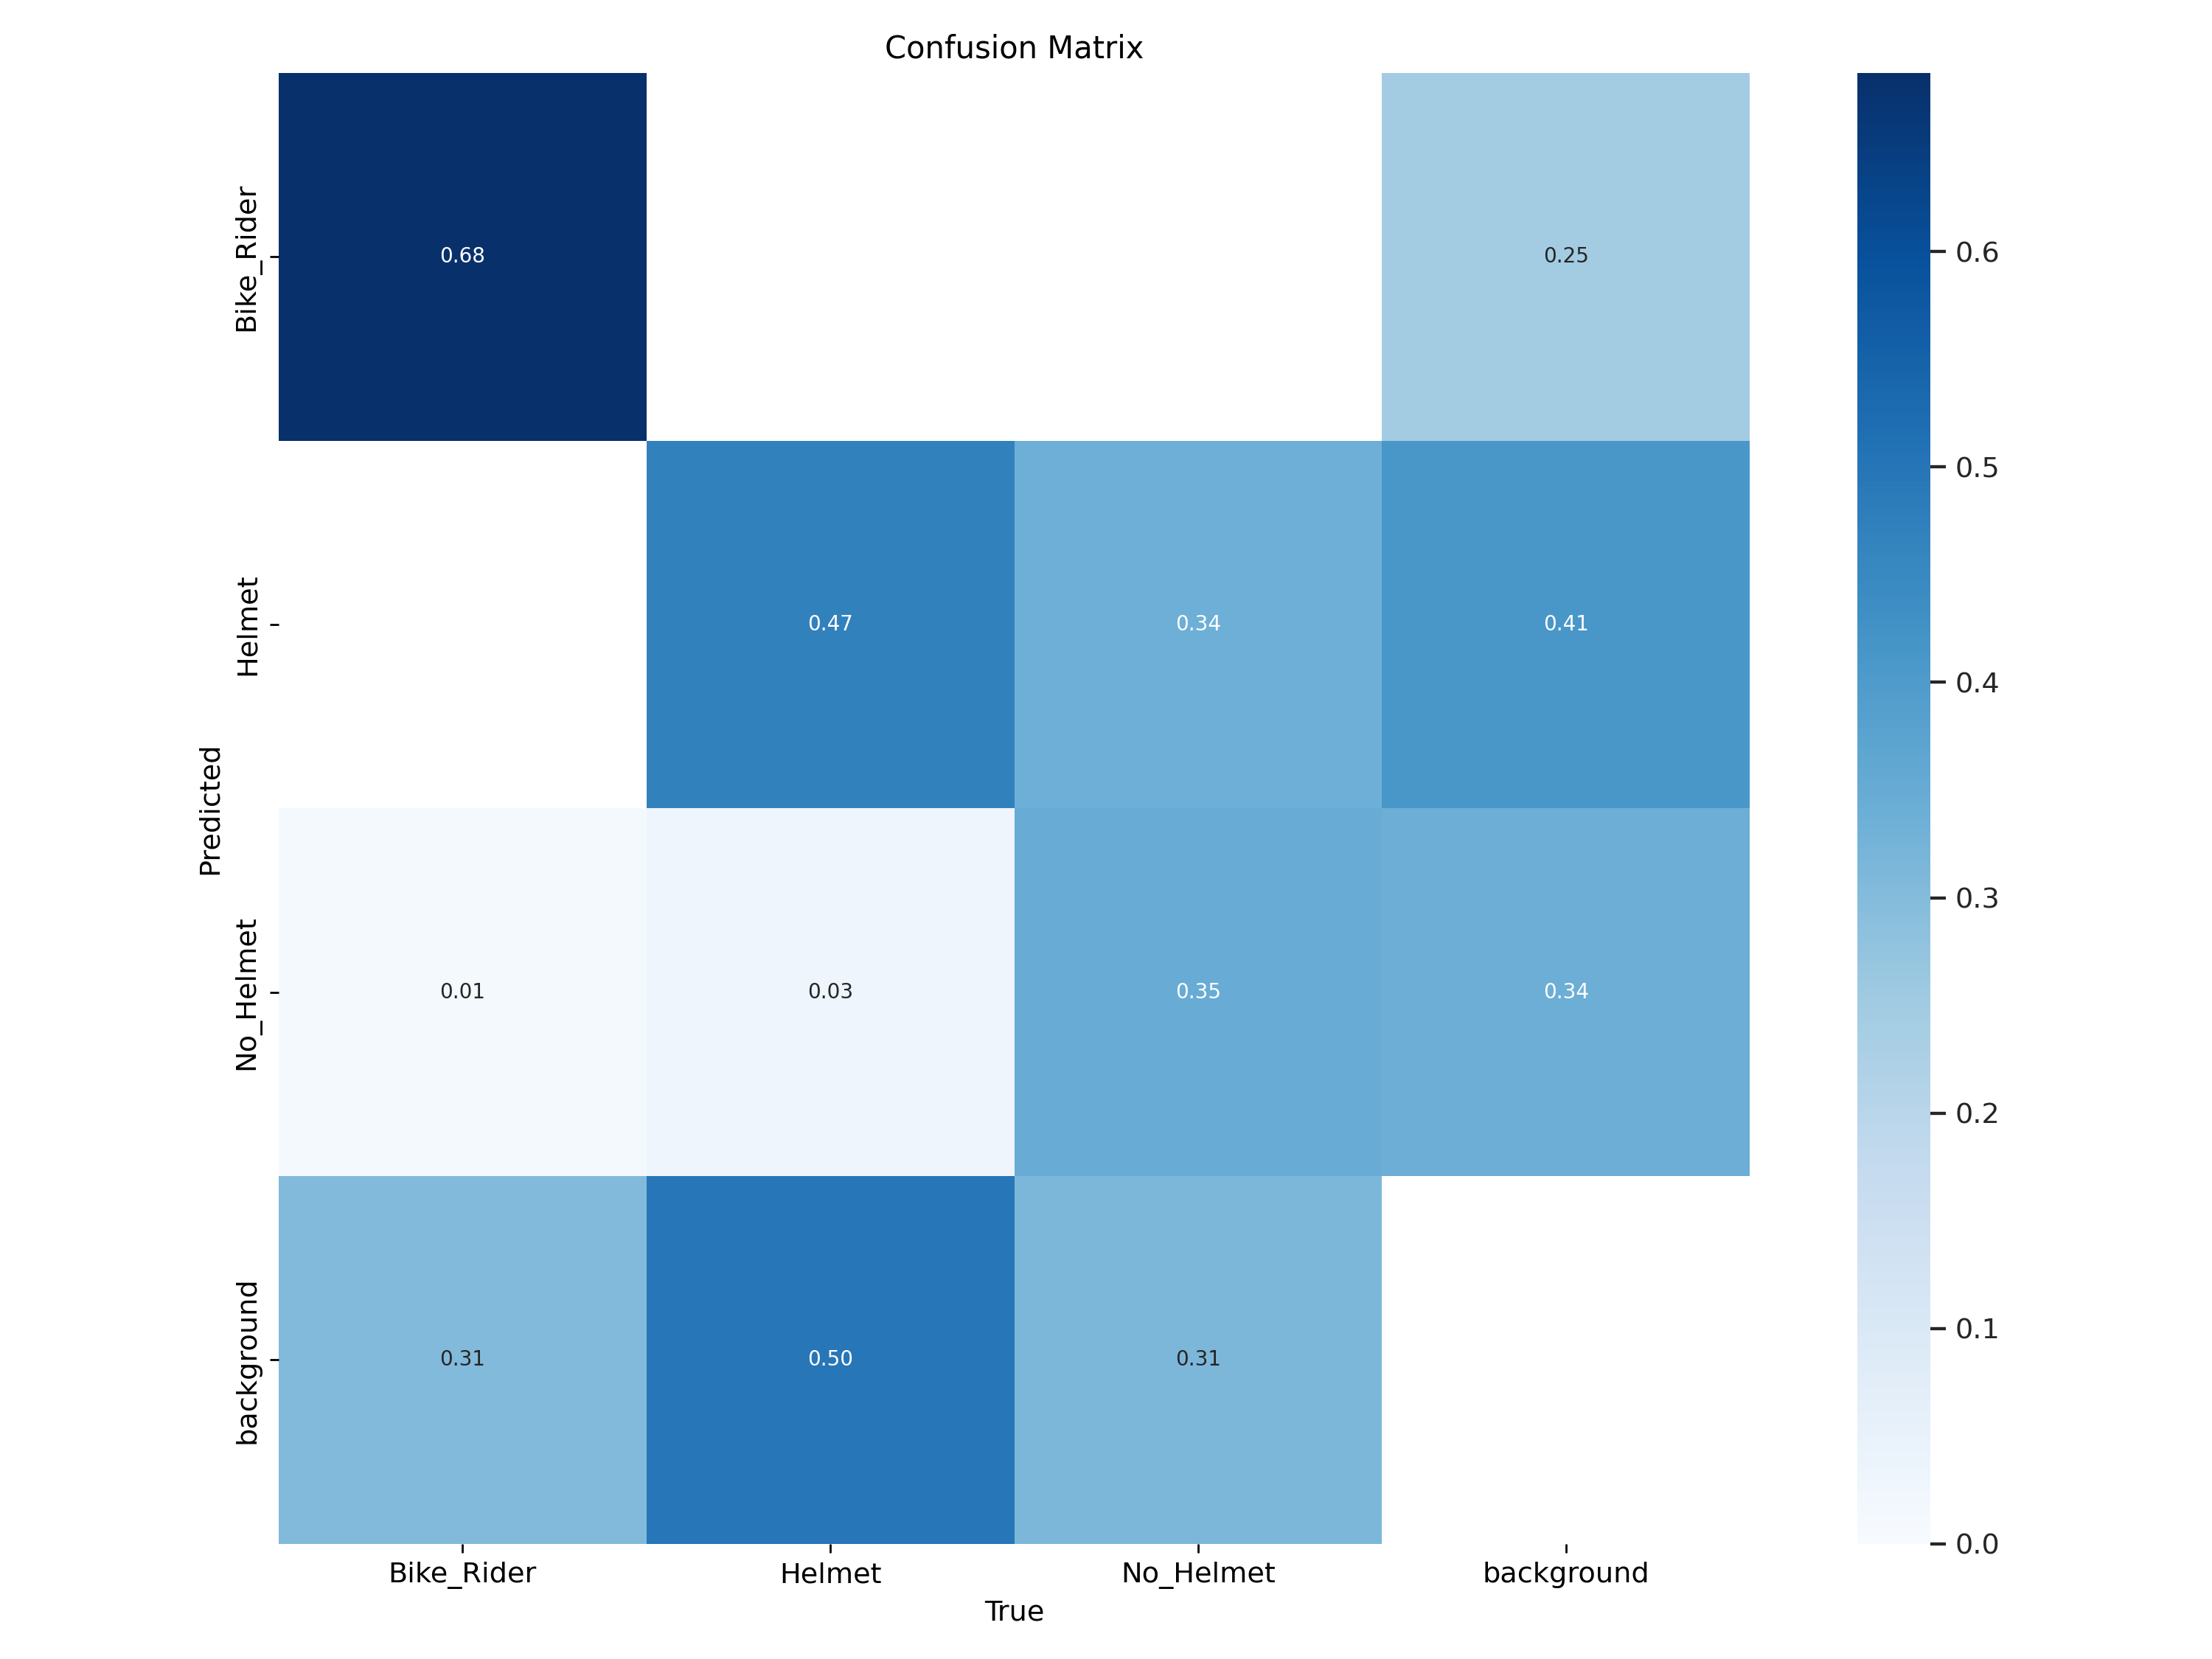

In [25]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


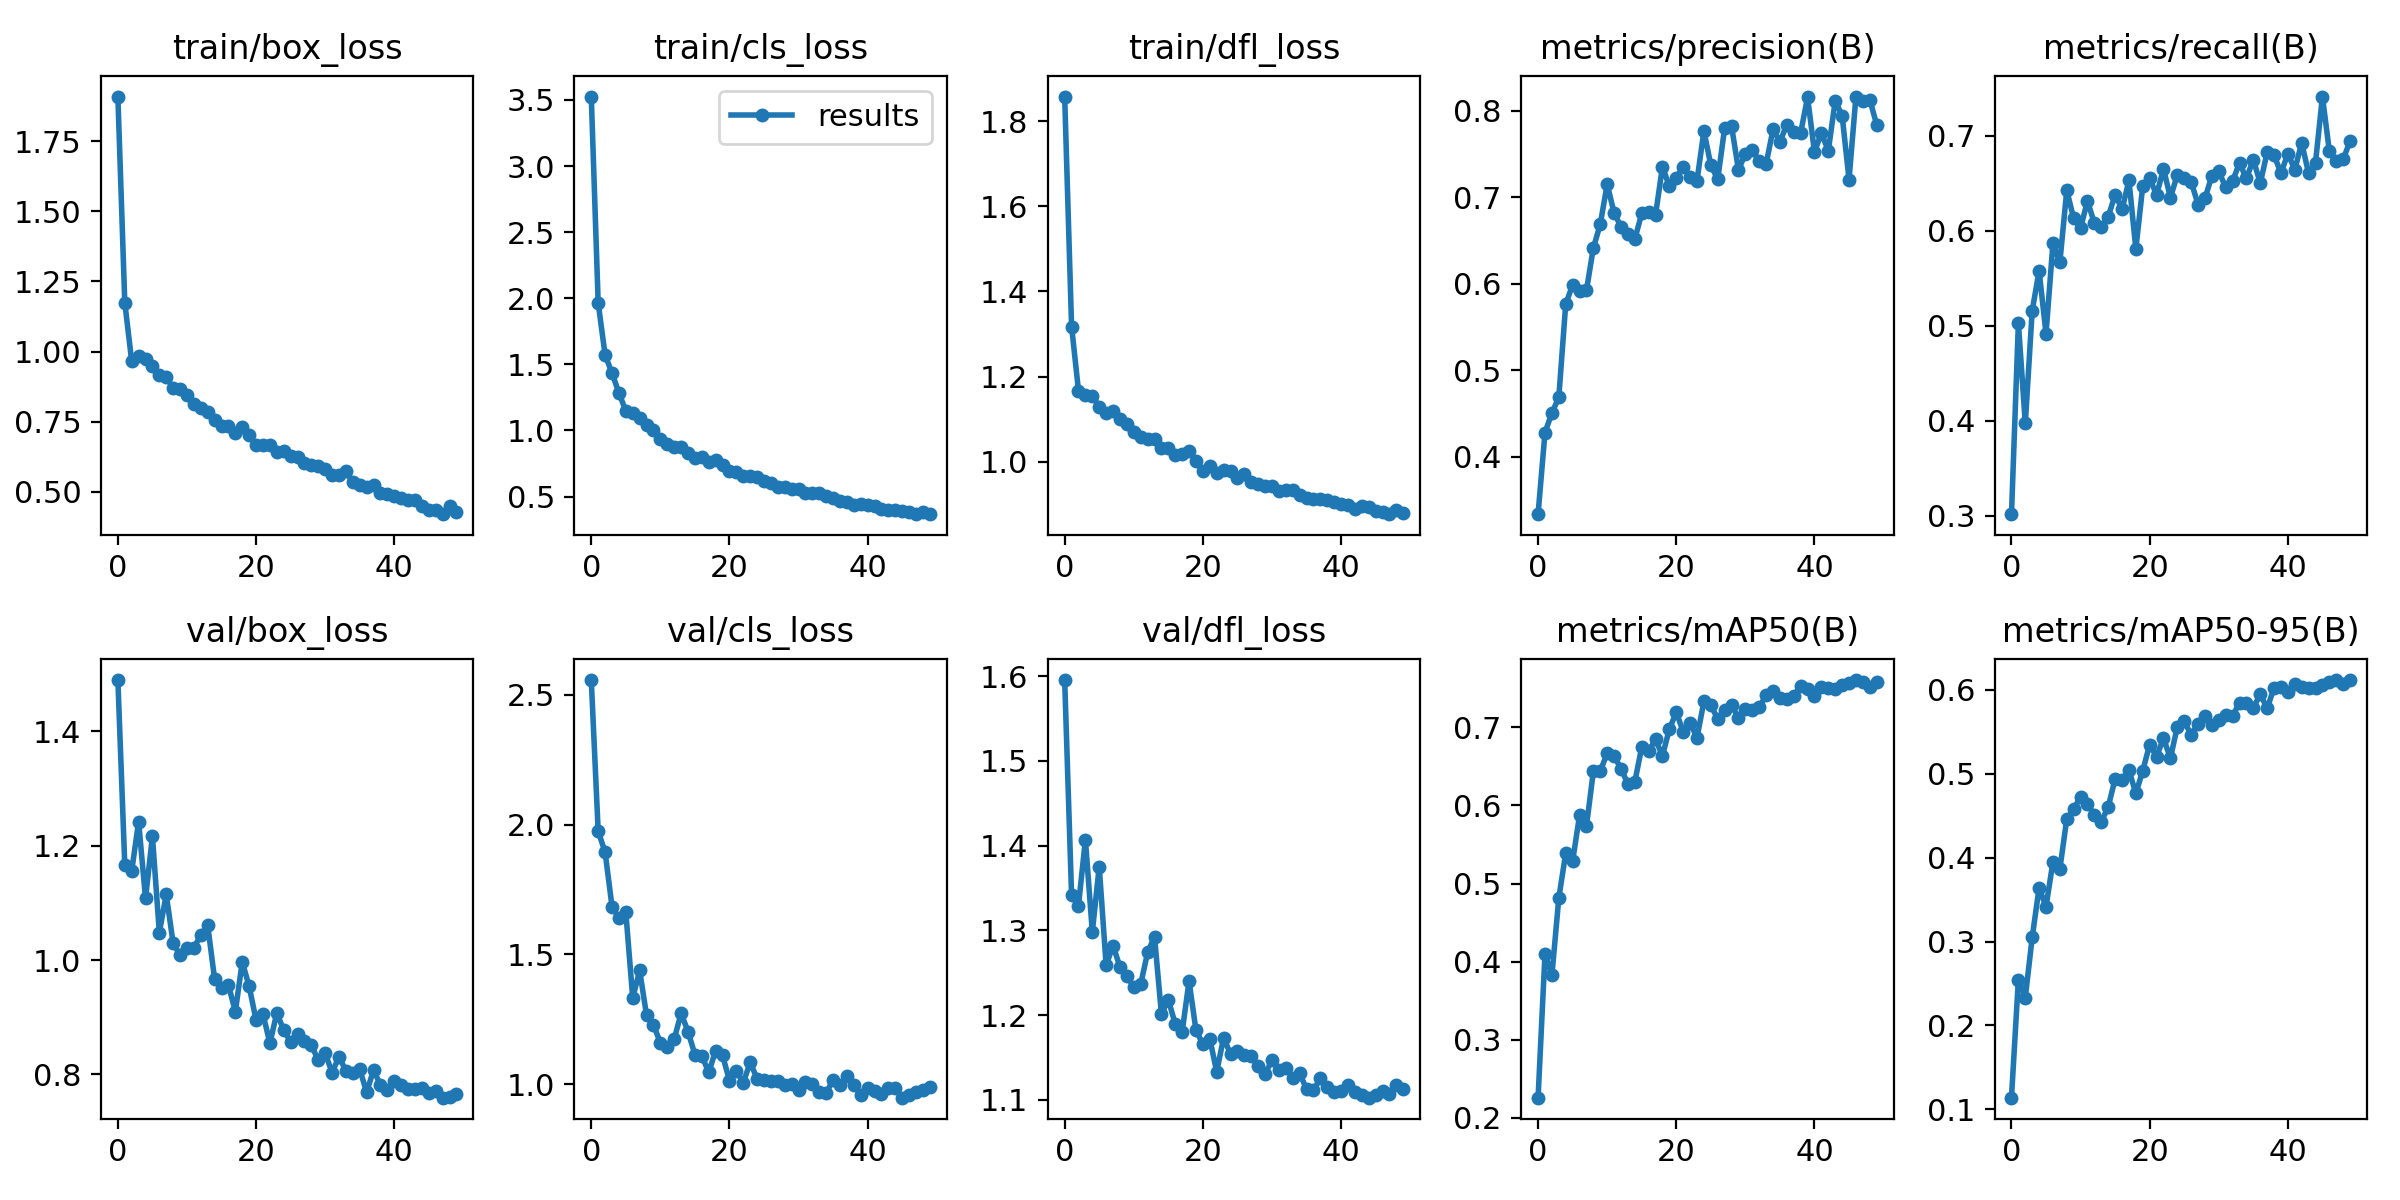

In [26]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


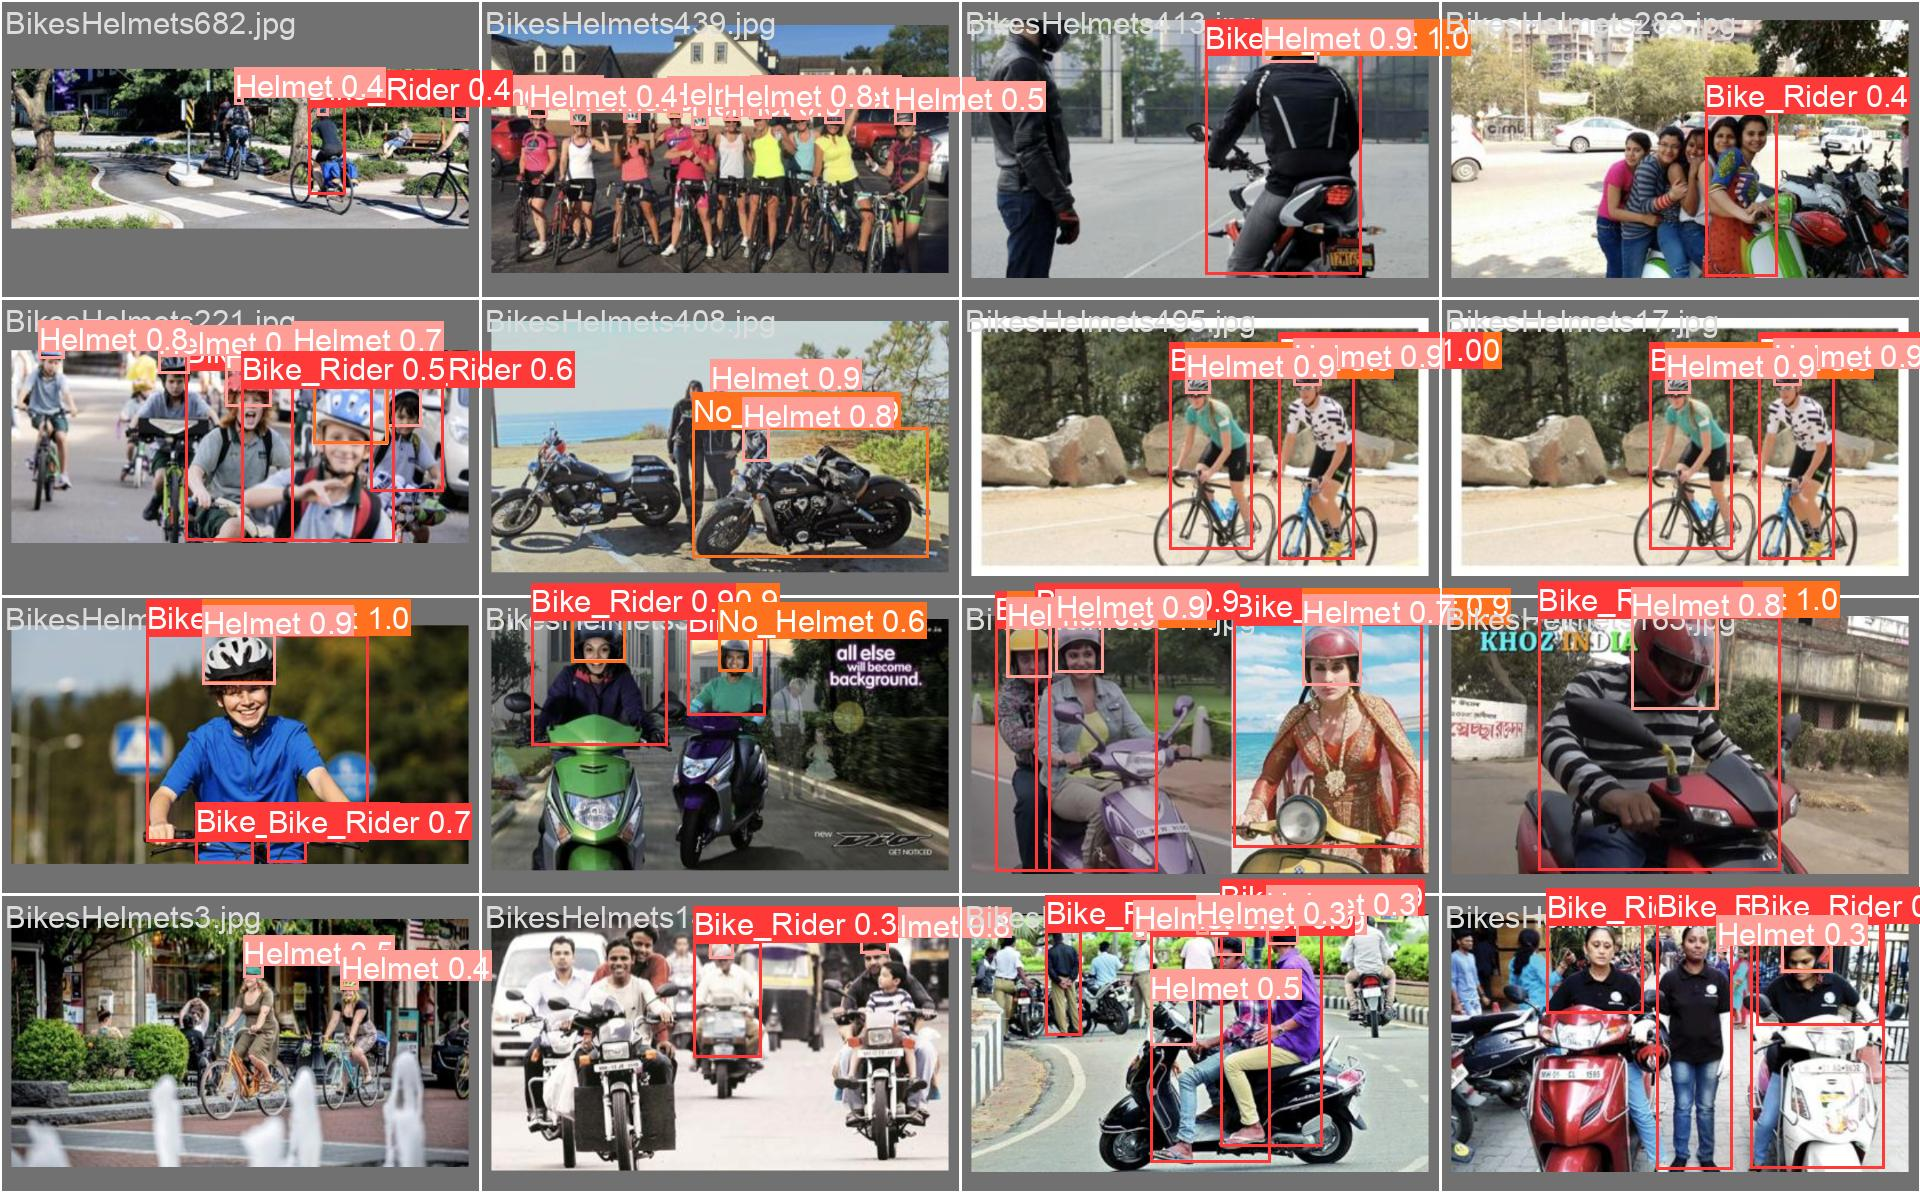

In [27]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## 🎬 Run Inference on a video

In [28]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [29]:
!mkdir -p /content/videos # Is is test too!

In [30]:
# TEST_VIDEO_PATHS = f"/content/videos/milk-video-1.mov"
INPUT_VIDEO_PATH = f"/content/videos/he2.mp4"
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [31]:
# # TEST_VIDEO_PATHS = f"/content/videos/milk-video-1.mov"
# INPUT_VIDEO_PATH = f"/content/videos/milk-video-1.mov"
# OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
# TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [32]:
# TEST_VIDEO_PATHS = f"/content/videos/milk-video-1.mov"
# INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
# OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
# TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [38]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43608921 parameters, 0 gradients, 164.8 GFLOPs

video 1/1 (1/224) /content/videos/he2.mp4: 384x640 7 Helmets, 1 No_Helmet, 79.6ms
video 1/1 (2/224) /content/videos/he2.mp4: 384x640 6 Helmets, 1 No_Helmet, 40.8ms
video 1/1 (3/224) /content/videos/he2.mp4: 384x640 9 Helmets, 1 No_Helmet, 40.8ms
video 1/1 (4/224) /content/videos/he2.mp4: 384x640 8 Helmets, 39.8ms
video 1/1 (5/224) /content/videos/he2.mp4: 384x640 7 Helmets, 1 No_Helmet, 39.9ms
video 1/1 (6/224) /content/videos/he2.mp4: 384x640 6 Helmets, 1 No_Helmet, 39.9ms
video 1/1 (7/224) /content/videos/he2.mp4: 384x640 8 Helmets, 1 No_Helmet, 28.4ms
video 1/1 (8/224) /content/videos/he2.mp4: 384x640 8 Helmets, 2 No_Helmets, 33.5ms
video 1/1 (9/224) /content/videos/he2.mp4: 384x640 6 Helmets, 34.6ms
video 1/1 (10/224) /content/videos/he2.mp4: 384x640 1 Bike_Rider, 7 Helmets, 1 No_Helmet, 33.9ms
video 1/1 (11/224) /

In [40]:
# TEST_VIDEO_PATHS = f"/content/videos/milk-video-1.mov"
INPUT_VIDEO_PATH = f"/content/videos/test_1.mp4"
OUTPUT_VIDEO_PATH = f"{HOME}/output_test_1.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43608921 parameters, 0 gradients, 164.8 GFLOPs

video 1/1 (1/461) /content/videos/test_1.mp4: 384x640 2 Bike_Riders, 3 Helmets, 1 No_Helmet, 74.1ms
video 1/1 (2/461) /content/videos/test_1.mp4: 384x640 2 Bike_Riders, 3 Helmets, 40.8ms
video 1/1 (3/461) /content/videos/test_1.mp4: 384x640 3 Bike_Riders, 5 Helmets, 1 No_Helmet, 40.8ms
video 1/1 (4/461) /content/videos/test_1.mp4: 384x640 1 Bike_Rider, 4 Helmets, 40.7ms
video 1/1 (5/461) /content/videos/test_1.mp4: 384x640 2 Bike_Riders, 7 Helmets, 1 No_Helmet, 39.9ms
video 1/1 (6/461) /content/videos/test_1.mp4: 384x640 1 Bike_Rider, 5 Helmets, 1 No_Helmet, 39.9ms
video 1/1 (7/461) /content/videos/test_1.mp4: 384x640 1 Bike_Rider, 4 Helmets, 1 No_Helmet, 39.9ms
video 1/1 (8/461) /content/videos/test_1.mp4: 384x640 1 Bike_Rider, 2 Helmets, 39.9ms
video 1/1 (9/461) /content/videos/test_1.mp4: 384x640 2 Helmets, 39.9ms
v

In [41]:
# TEST_VIDEO_PATHS = f"/content/videos/milk-video-1.mov"
INPUT_VIDEO_PATH = f"/content/videos/test_2.mp4"
OUTPUT_VIDEO_PATH = f"{HOME}/output_test_2.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43608921 parameters, 0 gradients, 164.8 GFLOPs

video 1/1 (1/1801) /content/videos/test_2.mp4: 384x640 2 Bike_Riders, 2 Helmets, 1 No_Helmet, 93.5ms
video 1/1 (2/1801) /content/videos/test_2.mp4: 384x640 1 Bike_Rider, 2 Helmets, 40.7ms
video 1/1 (3/1801) /content/videos/test_2.mp4: 384x640 1 Bike_Rider, 3 Helmets, 1 No_Helmet, 40.7ms
video 1/1 (4/1801) /content/videos/test_2.mp4: 384x640 1 Bike_Rider, 3 Helmets, 1 No_Helmet, 40.7ms
video 1/1 (5/1801) /content/videos/test_2.mp4: 384x640 1 Bike_Rider, 3 Helmets, 1 No_Helmet, 40.8ms
video 1/1 (6/1801) /content/videos/test_2.mp4: 384x640 1 Bike_Rider, 3 Helmets, 28.3ms
video 1/1 (7/1801) /content/videos/test_2.mp4: 384x640 3 Helmets, 1 No_Helmet, 28.3ms
video 1/1 (8/1801) /content/videos/test_2.mp4: 384x640 1 Bike_Rider, 3 Helmets, 1 No_Helmet, 28.3ms
video 1/1 (9/1801) /content/videos/test_2.mp4: 384x640 2 Bike_Riders,

## Export Model to Custom Python Script and Project

In [34]:
# yolo export model=yolov8n.pt

In [39]:
# !yolo detect model=yolov8n.pt source="/content/videos/he2.mp4" save_video="/content/output.mp4"

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/cfg/__init__.py", line 335, in entrypoint
    check_cfg_mismatch(full_args_dict, overrides)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/cfg/__init__.py", line 178, in check_cfg_mismatch
    raise SyntaxError(string + CLI_HELP_MSG) from e
SyntaxError: 'save_video' is not a valid YOLO argument. Similar arguments are i.e. ['save_period=-1', 'save_hybrid=False', 'save_json=False'].

    Arguments received: ['yolo', 'detect', 'model=yolov8n.pt', 'source=/content/videos/he2.mp4', 'save_video=/content/output.mp4']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of ('detect', 'segment', 'classify', 'pose')
                MODE (required) is one of ('train', 'val', 'predict', 'export', 'track', 'benchmark')
                AR

In [36]:
jhasdh92%-=304-

SyntaxError: ignored

In [42]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [43]:
!mkdir -p /content/gdrive/MyDrive/YOLOv8_Helmet_V0/
!cp -r /content/runs /content/gdrive/MyDrive/YOLOv8_Helmet_V0/
!cp -r /content/dataset /content/gdrive/MyDrive/YOLOv8_Helmet_V0/
!cp -r /content/images /content/gdrive/MyDrive/YOLOv8_Helmet_V0/
!cp -r /content/videos /content/gdrive/MyDrive/YOLOv8_Helmet_V0/
!cp -r /content/yolov8l.pt /content/gdrive/MyDrive/YOLOv8_Helmet_V0/
!cp -r /content/yolov8n.pt /content/gdrive/MyDrive/YOLOv8_Helmet_V0/

In [44]:
!cp -r /content/images /content/gdrive/MyDrive/YOLOv8_Helmet_V0/
!cp -r /content/videos /content/gdrive/MyDrive/YOLOv8_Helmet_V0/
!cp -r /content/yolov8l.pt /content/gdrive/MyDrive/YOLOv8_Helmet_V0/
!cp -r /content/yolov8n.pt /content/gdrive/MyDrive/YOLOv8_Helmet_V0/